In [ ]:
from google.colab import drive
import scipy.io as sio
import scipy
import numpy as np
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/Shareddrives/DeepLearning/Projecte_Final/Data/'
spec_path = '/content/drive/Shareddrives/DeepLearning/Projecte_Final/Spectograms/'
results_path = '/content/drive/Shareddrives/DeepLearning/Projecte_Final/Results/'

Mounted at /content/drive


## Creating the model and Data Loader

In [ ]:
import torch
import torchvision.transforms as tf

#Making native class loader
class SpecLoader(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path + 'SG_mat/Train_mat.mat',transform = None):
        mat_loaded = scipy.io.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[-1]

tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SpecTrain = SpecLoader(transform=tr)
train_loader = torch.utils.data.DataLoader(dataset=SpecTrain,
                                               batch_size=128, 
                                               shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image


class MyModel(nn.Module):
    def __init__(self, num_classes=6):
        
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.fc = nn.Linear(256*2*1, num_classes)

        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.norm1 = nn.BatchNorm2d(1)
        self.norm32 = nn.BatchNorm2d(32)
        self.norm64 = nn.BatchNorm2d(64)
        self.norm128 = nn.BatchNorm2d(128)

        self.drop = nn.Dropout2d(0.2)
        
                
    def forward(self, x):
        
        out = self.norm1(x)

        out = self.conv1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.norm32(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.norm32(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.norm64(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.norm64(out)

        out = self.conv5(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.norm128(out)

        out = self.conv6(out)
        out = self.relu(out)
        out = self.maxpool(out)

        #print(out.shape)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [ ]:
model = MyModel(num_classes=6)

In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

# Training and Testing the model

In [ ]:
#Train MyModel
my_model = MyModel()

#Initialize optimizer 
learning_rate = .05
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)

#optimizer = torch.optim.Adam(my_model.parameters(),lr = learning_rate, 
#                            weight_decay=1e-5)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='acc_97.ckpt', device=device)


Epoch [1/10], Step [32/32], Loss: 0.5989
Epoch [2/10], Step [32/32], Loss: 0.1205
Epoch [3/10], Step [32/32], Loss: 0.0347
Epoch [4/10], Step [32/32], Loss: 0.0199
Epoch [5/10], Step [32/32], Loss: 0.0079
Epoch [6/10], Step [32/32], Loss: 0.0028
Epoch [7/10], Step [32/32], Loss: 0.0032
Epoch [8/10], Step [32/32], Loss: 0.0009
Epoch [9/10], Step [32/32], Loss: 0.0003
Epoch [10/10], Step [32/32], Loss: 0.0002


Text(0, 0.5, 'Losss')

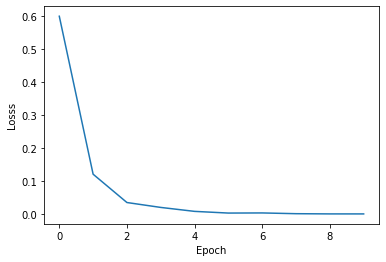

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_list)
plt.xlabel("Epoch")
plt.ylabel("Losss")


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Show results for all the trained models
SpecTest = SpecLoader(data_path + 'SG_mat/Test_mat.mat',transform=tr)
test_loader = torch.utils.data.DataLoader(dataset=SpecTest,
                                               batch_size=128, 
                                               shuffle=True)
#
my_net = MyModel()
my_net.load_state_dict(torch.load(results_path + 'my_net_iu.ckpt'))
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 97.07158351409979


## Example of normalized batch

In [ ]:
import matplotlib.pyplot as plt

# Actual usage of the data loader is as below.
for images, labels in train_loader:
  print(images.shape, labels.shape) #images, labels shape
  for img,lbl in zip(images,labels): 
    print('lbl : ',lbl)
    plt.imshow(tf.ToPILImage(mode='L')(img))
    plt.show()
  break

Output hidden; open in https://colab.research.google.com to view.